# 在 Rental Listing Inquiries 数据上练习分类方法

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss  

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索

In [2]:
# 读取训练数据
# path to where the data lies
dpath = '../../data/'
train = pd.read_json(dpath +"RentListingInquries_train.json")
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


### 特征含义
bathrooms: 浴室的数量

bedrooms: 卧室的数量

building_id：

created：发布时间

description：一些描述

display_address：展出地址

features: 公寓的一些特征

latitude：纬度

listing_id

longitude：经度

manager_id：管理ID

photos: 租房图片集

price: 美元

street_address：街道地址

interest_level: 目标变量，受欢迎程度. 有三个类: ‘high’, ‘medium’, ‘low’

In [4]:
train.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [5]:
for a in train.columns:
    print('%s = %d'% (a ,len(train[train[a]==0])))

bathrooms = 313
bedrooms = 9475
building_id = 0
created = 0
description = 0
display_address = 0
features = 0
interest_level = 0
latitude = 12
listing_id = 0
longitude = 12
manager_id = 0
photos = 0
price = 0
street_address = 0


In [7]:
## 各属性的统计特性
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [8]:
# 读取测试数据
# path to where the data lies
dpath = '../../data/'
test = pd.read_json(dpath +"RentListingInquries_test.json")
test.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


## 计算资源原因，只取500个样本进行试验

In [10]:
train=train[0:500]
test=test[0:500]

In [11]:
from scipy import sparse
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
features_to_use = ["bathrooms","bedrooms","latitude","longitude","price"]

In [13]:
# 照片数量(num_photos)
train['num_photos']=train['photos'].apply(len)
test['num_photos']=test['photos'].apply(len)
# 特征数量
train['num_features']=train['features'].apply(len)
test['num_features']=test['features'].apply(len)
# 描述词汇数量
train['num_description_words'] = train['description'].apply(lambda x: len(x.split(" ")))
test['num_description_words'] = test['description'].apply(lambda x: len(x.split(" ")))
#把创建的时间分解为多个特征        
train['created']=pd.to_datetime(train['created'])
test['created']=pd.to_datetime(test['created'])
 
#让我们从时间中分解出一些特征，比如年，月，日，时
#年
train['created_year'] = train['created'].dt.year
test['created_year'] = test['created'].dt.year
#月
train['created_month'] = train['created'].dt.month
test['created_month'] = test['created'].dt.month
#日
train['created_day'] = train['created'].dt.day
test['created_day'] = test['created'].dt.day
#时
train['created_hour'] = train['created'].dt.hour
test['created_hour'] = test['created'].dt.hour
#把这些特征都放到所需特征列表中（上面已经创建，并加入了数值型特征） 
features_to_use.extend(["num_photos","num_features","num_description_words","created_year","created_month","created_day","created_hour","listing_id"])


### 对字符串这类变量先做类别编码，后续考虑做独热编码

In [14]:
categorical = ["display_address","manager_id",'building_id',"street_address"]
for f in categorical:
    if train[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)+list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
        features_to_use.append(f)

### 将对房源的描述变为词库，进一步转化为词向量

In [15]:

train["features"] = train["features"].apply(lambda x:" ".join(["_".join(i.split(" "))for i in x]))
print (train['features'].head(2))
test['features'] = test["features"].apply(lambda x: " ".join(["_".join(i.split(" "))for i in x]))
print (test['features'].head(2))

10                                                        
10000    Doorman Elevator Fitness_Center Cats_Allowed D...
Name: features, dtype: object
0    Elevator Laundry_in_Building Laundry_in_Unit D...
1                    Pre-War Dogs_Allowed Cats_Allowed
Name: features, dtype: object


In [16]:
tfidf = CountVectorizer(stop_words ="english",max_features=200)
tr_sparse = tfidf.fit_transform(train["features"])
te_sparse = tfidf.transform(test["features"])

In [17]:
X_train = sparse.hstack([train[features_to_use],tr_sparse]).tocsr()
test = sparse.hstack([test[features_to_use],te_sparse]).tocsr()

In [19]:
target_num_map = {'high':0 , 'medium':1 , 'low':2}
y_train = np.array(train['interest_level'].apply(lambda x: target_num_map[x]))
print (X_train.shape,test.shape,y_train.shape)

(500, 140) (500, 140) (500,)


## 数据集划分

In [20]:
def data_set_split(X,Y):
    from sklearn.cross_validation import train_test_split
    #random_state=42 保证每次分组一致，保证模型稳定
    X_train, X_test, y_train,y_test = train_test_split(X, Y, test_size=0.2) 
    return X_train, X_test, y_train, y_test


In [21]:
X_train, X_test, y_train, y_test=data_set_split(X_train,y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 数据预处理

In [22]:
# 数据标准化
#from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
#ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
#X_train = ss_X.fit_transform(X_train)
#X_test = ss_X.transform(X_test)


将0.2的数据作为测试集

In [23]:
print(X_train.shape,X_test.shape)

(400, 140) (100, 140)


## 模型训练

### default Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()

In [25]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_log_loss')

In [28]:
print ('logloss of each fold is: ',-loss)
print ('cv logloss is:', -loss.mean())

logloss of each fold is:  [0.80527974 0.7671725  0.80183464 0.77380223 0.77206277]
cv logloss is: 0.7840303752329437


### 正则化的 Logistic Regression及参数调优

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 
目标函数为：J = sum(logloss(f(xi), yi)) + C* penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
设置候选参数集合
调用GridSearchCV
调用fit

### 用LogisticRegressionCV实现正则化的 Logistic Regression

### L1正则

In [30]:
from sklearn.linear_model import LogisticRegressionCV

#Cs = [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,1,10,100,1000]
Cs=[i/10 for i in range(1,100)]
# LogisticRegressionCV比GridSearchCV快
lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l1', solver='liblinear')
lrcv_L1.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9],
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring='neg_log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [31]:
lrcv_L1.scores_

{0: array([[-0.28315036, -0.27677367, -0.28224789, -0.27943279, -0.27476398,
         -0.27362478, -0.27350612, -0.27473198, -0.274424  , -0.27466628,
         -0.28224883, -0.27722101, -0.27923827, -0.28113695, -0.2839096 ,
         -0.28627463, -0.288545  , -0.29107023, -0.29437894, -0.29892599,
         -0.29814703, -0.30190568, -0.30305868, -0.3050048 , -0.30719139,
         -0.30915226, -0.31113706, -0.31320841, -0.31557381, -0.31706089,
         -0.31874583, -0.32109725, -0.325404  , -0.32541969, -0.32846674,
         -0.32980726, -0.33263749, -0.33564118, -0.33651302, -0.33926974,
         -0.34004291, -0.3423762 , -0.34685097, -0.3467379 , -0.34839428,
         -0.35054321, -0.35169222, -0.35372974, -0.35704471, -0.35559512,
         -0.35960838, -0.36074846, -0.36005359, -0.36144918, -0.36310097,
         -0.36748456, -0.36883973, -0.36998209, -0.37102039, -0.3732604 ,
         -0.37145319, -0.37628108, -0.37779057, -0.37576302, -0.37802428,
         -0.38062148, -0.3829548 , 

[-0.53587315 -0.53592805 -0.53775672 -0.53818725 -0.53646738 -0.53762102
 -0.53955635 -0.54208001 -0.54491982 -0.54794139 -0.54850736 -0.55312289
 -0.55630331 -0.56074496 -0.56184847 -0.5615772  -0.56802398 -0.57001991
 -0.57249087 -0.57623672 -0.57795046 -0.57882736 -0.58282645 -0.58318922
 -0.58582839 -0.58892781 -0.58913027 -0.59223611 -0.59577506 -0.59702053
 -0.59977728 -0.60015241 -0.60342762 -0.60579222 -0.60296711 -0.60201861
 -0.60711443 -0.60125424 -0.60768051 -0.61014637 -0.61164588 -0.61591159
 -0.60692091 -0.61802328 -0.61489024 -0.61505718 -0.61884914 -0.61368159
 -0.62207889 -0.62286797 -0.62365786 -0.61757098 -0.62618018 -0.62678724
 -0.62460699 -0.62818088 -0.62950039 -0.63190529 -0.63252918 -0.62920895
 -0.63444525 -0.63518352 -0.63398123 -0.62925992 -0.63645749 -0.63561383
 -0.6356459  -0.63900224 -0.63497182 -0.64365008 -0.64257358 -0.63859592
 -0.63692171 -0.63874983 -0.64190614 -0.64178901 -0.64461534 -0.63737571
 -0.64350195 -0.64418454 -0.64845267 -0.64607548 -0

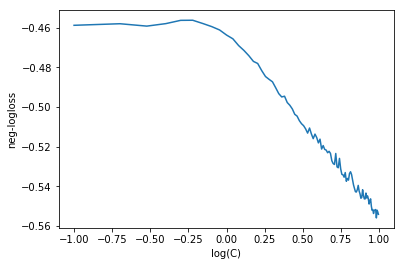

In [32]:
# dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))
print(np.mean(lrcv_L1.scores_[1],axis = 0))
for j in range(n_classes):
    scores[j][:] = np.mean(lrcv_L1.scores_[j],axis = 0)
    
mse_mean = np.mean(scores, axis = 0)
plt.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

#print ('C is:',lr_cv.C_)  #对多类分类问题，每个类别的分类器有一个C

In [33]:
lrcv_L1.coef_

array([[ 0.00000000e+00,  5.00800483e-01,  0.00000000e+00,
         0.00000000e+00, -8.88914767e-04, -9.57251506e-02,
        -4.68696169e-02,  5.85329186e-03,  1.30309739e-04,
         0.00000000e+00, -2.95246453e-02,  3.90704268e-02,
         3.56097184e-08, -1.52677496e-03, -1.09208569e-03,
         1.35824354e-03, -8.79745845e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.86668846e-03, -1.15388667e-0

In [34]:
print ('best C  is:',lrcv_L1.C_)

best C  is: [0.5 0.1 0.6]


LogisticRegressionCV + L1正则 最优C选择

In [35]:
#使用测试集对模型进行预测
from sklearn import *
pre_test_logis_L1=lrcv_L1.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (lrcv_L1, metrics.classification_report(y_test, pre_test_logis_L1)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, pre_test_logis_L1))

Classification report for classifier LogisticRegressionCV(Cs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9],
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring='neg_log_loss', solver='liblinear', tol=0.0001,
           verbose=0):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.50      0.14      0.22  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
#对测试集进行预测
def test_data_pred(lr,X_test):
    pre_test=lr.predict(X_test)
    out_df = pd.DataFrame(pre_test)
    out_df.columns =['result']
    out_df.replace({0:"high",1:"medium",2:"low"},inplace=True)
    #out_df["listing_id"] = X_test.listing_id.values
    out_df.to_csv("test_result.csv", index=False)

# 预测

In [41]:
test_data_pred(lrcv_L1,test)

### L2正则

In [39]:
from sklearn.linear_model import LogisticRegressionCV

#Cs = [1, 10,100,1000]
Cs=[i/100 for i in range(1,10000)]

# 大量样本（6W+）、高维度（93），L2正则 --> 缺省用lbfgs，为了和GridSeachCV比较，也用liblinear

lr_cv_L2 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l2', solver='liblinear', multi_class='ovr')
lr_cv_L2.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0...85, 99.86, 99.87, 99.88, 99.89, 99.9, 99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99],
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring='neg_log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [42]:
lr_cv_L2.scores_

{0: array([[-0.27721437, -0.27721437, -0.27721436, ..., -0.27721436,
         -0.27721436, -0.27721436],
        [-0.26740198, -0.26740196, -0.26740196, ..., -0.26740195,
         -0.26740195, -0.26740195],
        [-0.3155916 , -0.31559168, -0.3155917 , ..., -0.31559176,
         -0.31559176, -0.31559176],
        [-0.24918631, -0.2491863 , -0.2491863 , ..., -0.2491863 ,
         -0.2491863 , -0.2491863 ],
        [-0.27272327, -0.27272327, -0.27272327, ..., -0.27272327,
         -0.27272327, -0.27272327]]),
 1: array([[-0.56079332, -0.56079333, -0.56079333, ..., -0.56079333,
         -0.56079333, -0.56079333],
        [-0.54098011, -0.54098011, -0.54098011, ..., -0.54098011,
         -0.54098011, -0.54098011],
        [-0.52214109, -0.52214108, -0.52214108, ..., -0.52214108,
         -0.52214108, -0.52214108],
        [-0.55450711, -0.55450713, -0.55450713, ..., -0.55450715,
         -0.55450715, -0.55450715],
        [-0.52778551, -0.5277855 , -0.5277855 , ..., -0.5277855 ,
        

[-0.54124143 -0.54124143 -0.54124143 ... -0.54124143 -0.54124143
 -0.54124143]


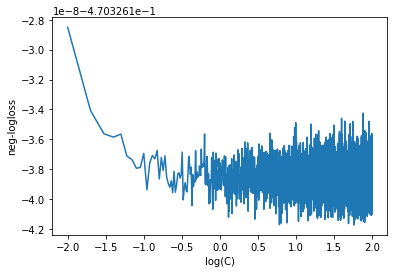

best C  is: [1.000e-02 1.000e-02 7.665e+01]


In [43]:
# dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))
print(np.mean(lr_cv_L2.scores_[1],axis = 0))
for j in range(n_classes):
    scores[j][:] = np.mean(lr_cv_L2.scores_[j],axis = 0)
    
mse_mean = np.mean(scores, axis = 0)
plt.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

print ('best C  is:',lr_cv_L2.C_)  #对多类分类问题，每个类别的分类器有一个C

In [44]:
test_data_pred(lr_cv_L2,test)


# 支持向量机分类回归问题

In [45]:
#LinearSVC不能得到每类的概率，在Otto数据集要求输出每类的概率，这里只是示意SVM的使用方法
#https://xacecask2.gitbooks.io/scikit-learn-user-guide-chinese-version/content/sec1.4.html
#1.4.1.2. 得分与概率
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

SVC1 = LinearSVC().fit(X_train, y_train)

In [46]:
#在校验集上测试，估计模型性能
y_predict = SVC1.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_test, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.37      0.54      0.43        28
          2       0.71      0.65      0.68        65

avg / total       0.57      0.57      0.56       100


Confusion matrix:
[[ 0  3  4]
 [ 0 15 13]
 [ 0 23 42]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
test_data_pred(SVC1,test)

### 线性SVM正则参数调优

线性SVM LinearSVC的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [48]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC2 =  LinearSVC( C = C,penalty='l2')
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("accuracy: {}".format(accuracy),"C=%f"%(C))
    return accuracy

accuracy: 0.65 C=0.010000
accuracy: 0.3 C=0.021544
accuracy: 0.28 C=0.046416
accuracy: 0.18 C=0.100000
accuracy: 0.65 C=0.215443
accuracy: 0.65 C=0.464159
accuracy: 0.65 C=1.000000
accuracy: 0.65 C=2.154435
accuracy: 0.61 C=4.641589
accuracy: 0.65 C=10.000000


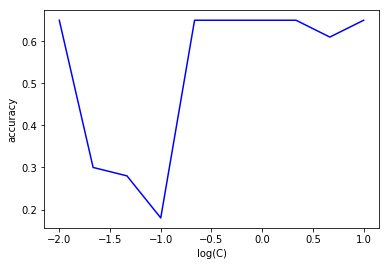

In [49]:
#需要调优的参数
C_s = np.logspace(-2, 1, 10)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = []
for i, oneC in enumerate(C_s):
#    for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train, y_train, X_test, y_test)
    accuracy_s.append(tmp)

x_axis = np.log10(C_s)
#for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.savefig('SVM_Otto.png' )

plt.show()

### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [50]:
from sklearn.svm import SVC

In [51]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC3 =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC3.score(X_val, y_val)
    
    print("accuracy: {}".format(accuracy),"C=%f"%(C),"gamma=%f"%(gamma))
    return accuracy

In [52]:
#需要调优的参数
C_s = np.logspace(-2, 1, 10)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)    

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_test, y_test)
        accuracy_s.append(tmp)

accuracy: 0.65 C=0.010000 gamma=0.010000
accuracy: 0.65 C=0.010000 gamma=0.100000
accuracy: 0.65 C=0.010000 gamma=1.000000
accuracy: 0.65 C=0.010000 gamma=10.000000
accuracy: 0.65 C=0.010000 gamma=100.000000
accuracy: 0.65 C=0.021544 gamma=0.010000
accuracy: 0.65 C=0.021544 gamma=0.100000
accuracy: 0.65 C=0.021544 gamma=1.000000
accuracy: 0.65 C=0.021544 gamma=10.000000
accuracy: 0.65 C=0.021544 gamma=100.000000
accuracy: 0.65 C=0.046416 gamma=0.010000
accuracy: 0.65 C=0.046416 gamma=0.100000
accuracy: 0.65 C=0.046416 gamma=1.000000
accuracy: 0.65 C=0.046416 gamma=10.000000
accuracy: 0.65 C=0.046416 gamma=100.000000
accuracy: 0.65 C=0.100000 gamma=0.010000
accuracy: 0.65 C=0.100000 gamma=0.100000
accuracy: 0.65 C=0.100000 gamma=1.000000
accuracy: 0.65 C=0.100000 gamma=10.000000
accuracy: 0.65 C=0.100000 gamma=100.000000
accuracy: 0.65 C=0.215443 gamma=0.010000
accuracy: 0.65 C=0.215443 gamma=0.100000
accuracy: 0.65 C=0.215443 gamma=1.000000
accuracy: 0.65 C=0.215443 gamma=10.000000
acc

从上述部分运行结果来看，gamma参数设置不合适（gamma越大，对应RBF核的sigma越小，决策边界更复杂，可能发生了过拟合）
所以调小gamma值

In [53]:
#需要调优的参数
C_s = np.logspace(-1, 3, 10)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-8, -8, 1)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_test, y_test)
        accuracy_s.append(tmp)

accuracy: 0.65 C=0.100000 gamma=0.000000
accuracy: 0.65 C=0.278256 gamma=0.000000
accuracy: 0.65 C=0.774264 gamma=0.000000
accuracy: 0.64 C=2.154435 gamma=0.000000
accuracy: 0.66 C=5.994843 gamma=0.000000
accuracy: 0.66 C=16.681005 gamma=0.000000
accuracy: 0.63 C=46.415888 gamma=0.000000
accuracy: 0.62 C=129.154967 gamma=0.000000
accuracy: 0.54 C=359.381366 gamma=0.000000
accuracy: 0.52 C=1000.000000 gamma=0.000000


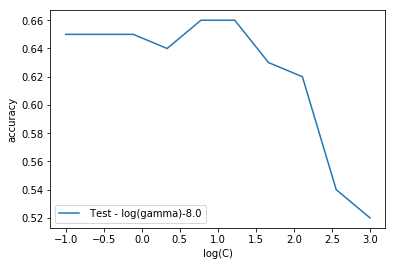

In [54]:
accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))

plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.savefig('RBF_SVM_Otto.png' )

plt.show()

# 预测 ,使用accuracy: 0.65 C=0.774264 gamma=0.000000

In [55]:
# 在训练集是那个利用SVC训练
SVC3 =  SVC( C = 46.415888 , kernel='rbf', gamma = 'auto')
SVC3 = SVC3.fit(X_train, y_train)

# 预测
test_data_pred(SVC3,test)